#CS3244 Lecture 3: Overfitting and Bayesian Linear Regression
- Instructor: Harold Soh
- TAs: Eugene Lim, Yang Mingyang
- Date: 16 May 2022
- Version: 0.1

DISCLAIMER: Code prepared for educational purposes and to illustrate the key concepts. This code is implemented following the standard equations which is not efficient and can be numerically unstable. As we go through, we will mention some ways things should be implemented. The code may also have errors. Please report bugs on our piazza site.  

In [ ]:
%matplotlib inline

import numpy as np
from scipy import optimize

from numpy.random import randn, random_sample
from numpy import log, exp
from numpy.linalg import inv, pinv, norm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
# some helper functions (you can recognize this from L1)
# plot the data
def plotData(xs, ts, fig=None, ax=None):
    # plot the data
    if (fig is None) or (ax is None):
      fig, ax = plt.subplots()
    ax.scatter(xs,ts)
    ax.set_title('Our data')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    
    return fig, ax

# this is the underlying real nonlinear function 
def h(xs):
    return -xs + np.sin(4*np.pi*xs)

# generate the polynomial basis up to some order
def polyBasis(xs, order):
    xo = xs.transpose().reshape(-1,1)
    X = np.ones(len(xs))
    #X = np.c_[np.ones(X_o.shape[0]), X_o]
    for i in np.arange(1, order+1):
        X = np.c_[X, pow(xo, i)]
    return X

# fit a polynomial
def fitPolyReg(xs, ts, order, lbd):
    Phi = polyBasis(xs, order)
    T = ts.transpose().reshape(-1,1)
    w = inv(Phi.transpose() @ Phi + lbd*np.identity(Phi.shape[1])) @ Phi.transpose() @ T
    return w

# plot the fit
def plotPolyFit(xs, ts, xp, w, order, do_plot=True, plot_data=False, fig=None, ax=None):
    Phi = polyBasis(xp, order)
    ys = Phi @ w
    if do_plot:
      if plot_data:
        fig, ax = plotData(xs,ts, fig, ax)
      ax.plot(xp, ys, 'r')
      return fig, ax


# generate gaussian basis up at some locations
def RBF(xs, locs, shape):
  xo = xs.transpose().reshape(-1,1)
  X = np.ones(len(xs))
  for l in locs:
    X = np.c_[X, exp(-np.power(xo - l, 2.0)/shape ) ]
  return X

# fit a RBF regressor
def fitRBFReg(xs, ts, locs, shape, lbd):
  Phi = RBF(xs, locs, shape)
  T = ts.transpose().reshape(-1,1)
  w = pinv(Phi.transpose() @ Phi + lbd*np.identity(Phi.shape[1])) @ Phi.transpose() @ T
  return w

def predRBF(xp, w, locs, shape):
  Phi = RBF(xp, locs, shape)
  ys = Phi @ w
  return ys
  
# plot the fit
def plotRBFFit(xs, ts, xp, w, locs, shape, do_plot=True, plot_data=False, fig=None, ax=None):
    ys = predRBF(xp, w, locs, shape)
    if do_plot:
      if plot_data:
        fig, ax = plotData(xs,ts, fig, ax)
      ax.plot(xp, ys, 'r')
      return fig, ax

## Curves that emerge from Different Datasets

As in Lecture 1, Let's create some data using a nonlinear function. We'll use this data to again illustrate how the data is generated. 

Rather than the evenly spaced data from Lecture 1, we are going to
1. randomly sample N data points where N is small (say 10) 
2. fit a (regularized) RBF regressor to the data points.

We repeat this T times to have a look at the variance between the fits. 

[-0.5  -0.35 -0.2  -0.05  0.1   0.25  0.4   0.55  0.7   0.85  1.    1.15
  1.3   1.45]


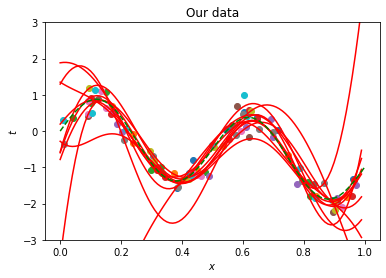

In [ ]:
# set the seed so the results are reproducible
np.random.seed(0)

# Parameters (you can change these)
# experiment parameters
T = 200 # number of curves to fit
N = 10 # number of data points
beta = 20 # label/target noise

# polynomial model parameters 
# order = 7 #specify the order of the polynomial
lbd = exp(-10)
# M = order + 1

# RBF parameters
shape = 0.10
locs = np.array(np.arange(-0.5, 1.5, 0.15))
print(locs)
M = len(locs) + 1

def genData(N, beta):
  xs_nl = np.random.rand(N)
  ts_nl = h(xs_nl) + np.sqrt(1.0/beta)*randn(N)
  return (xs_nl, ts_nl)

fig = None
ax = None 

w = np.zeros((M, T))

fig, ax = plt.subplots()
for i in range(T):
  xs,ts = genData(N, beta)
  
  w[:,i] = fitRBFReg(xs, ts, locs, shape, lbd).reshape(-1,M)
  #w[:,i] = fitPolyReg(xs, ts, order, lbd).reshape(-1,order+1)
  
  xp = np.arange(0,1,0.01)
  if (i % 20) == 0:
    fig, ax = plotRBFFit(xs, ts, xp, w[:,i], locs, shape, plot_data=True, fig=fig, ax=ax)
    #fig, ax = plotPolyFit(xs, ts, xp, w, order, plot_data=True, fig=fig, ax=ax)
  
#ax.set_title('Polynomial Order %d'%order)
ax.set_ylim([-3, 3])

xp = np.arange(0,1.01,0.01)
ax.plot(xp, h(xp), 'g--')

As you can see, each individual fit in the model isn't particularly good since we only have 10 data points for each fit. Also, there is a great deal of variability between the models ("variance"). However, something interesting happens when you "average" these models together. 

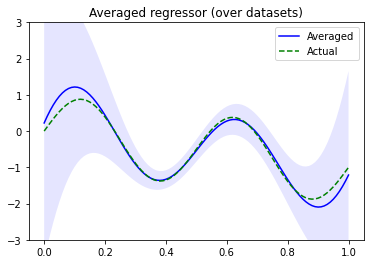

In [ ]:
# Let's compute the average predictor 
#("monte-carlo" approach, i.e., by averaging over the drawn samples)

xp = np.arange(0,1.01,0.01)
#Phi = polyBasis(xp, order)
Phi = RBF(xp, locs, shape)

N_test = len(xp)
ys = np.zeros((N_test, T))

# slow way... figure out a more efficient approach. :)
for i in range(T):
  ys[:,i] = Phi @ w[:,i]

ys_mean = np.average(ys, axis=1)
ys_std = np.std(ys, axis=1)

fig, ax = plt.subplots()
ax.plot(xp, ys_mean, 'b', label= "Averaged")
ax.fill_between(xp, ys_mean - ys_std,  ys_mean + ys_std, facecolor='blue', alpha=0.1)

ax.plot(xp, h(xp), 'g--', label="Actual")
ax.set_ylim([-3, 3])
ax.legend()
ax.set_title("Averaged regressor (over datasets)")
fig.show()

The average predictor seems to be quite a good one. The shaded regions give us the standard deviation across the different learned models. 

## Bayesian Linear Regression
Let us now perform Bayesian linear regression. We'll program the equations we developed in lecture. Recall that now, we will maintain a posterior over the weights. 

In [ ]:
# Learning
def learnBayesianLR(xs, ts, locs, shape):
  Phi = RBF(xs, locs, shape)
  T = ts.transpose().reshape(-1,1)
  Sinv_N = (beta* Phi.transpose() @ Phi) + alpha*np.identity(Phi.shape[1])
  S_N = pinv(Sinv_N)
  m_N = beta* (S_N @ Phi.transpose() @ T)
  return m_N, S_N


def predictBayesianLR(xp, m_N, S_N):
  # Predictions
  ys_mean_bayes = np.zeros(xp.shape)
  ys_std_bayes = np.zeros(xp.shape)

  # make predictions for each test point 
  for i in range(len(xp)):
    xt = xp[i] 
    Phi_test = RBF(np.array([xt]), locs, shape).reshape(M,-1)
    ys_mean_bayes[i] = m_N.transpose() @ Phi_test
    ys_std_bayes[i] = np.sqrt(1.0/beta + (Phi_test.transpose() @ S_N @ Phi_test))

  return (ys_mean_bayes, ys_std_bayes)


def plotBayesianLR(xp, ys_mean_bayes, ys_std_bayes):
  # plotting
  fig, ax = plt.subplots()
  ax.plot(xp, ys_mean_bayes, 'b', label= "Mean Prediction")
  ax.fill_between(xp, ys_mean_bayes - ys_std_bayes,  ys_mean_bayes + ys_std_bayes, 
                  facecolor='blue', alpha=0.1)
  ax.set_ylim([-3, 3])
  ax.legend()
  ax.set_title("Bayesian regressor")
  fig.show()
  return fig, ax

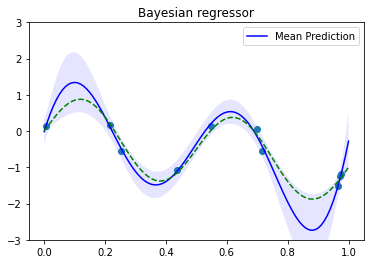

In [ ]:
# Learn from a small number of points
seed = 4
np.random.seed(seed)

alpha = 0.001 # (alpha^-1)*I is the covariance

N = 10
xs,ts = genData(N, beta)


# learn
m_N, S_N = learnBayesianLR(xs, ts, locs=locs, shape=shape)

# prediction 
xp = np.array(np.arange(0.0, 1.01, 0.01)) #test points
ys_mean_bayes, ys_std_bayes = predictBayesianLR(xp, m_N, S_N)

# plotting 
fig, ax = plotBayesianLR(xp, ys_mean_bayes, ys_std_bayes)

ax.plot(xp, h(xp), 'g--', label="Actual")
ax.scatter(xs,ts)

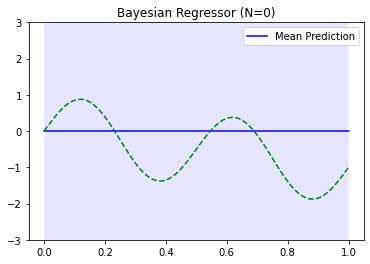

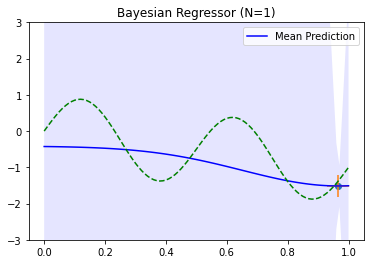

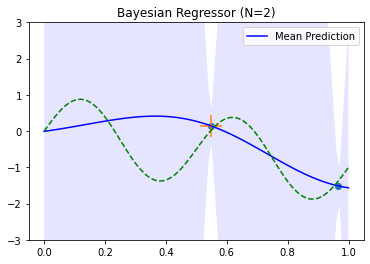

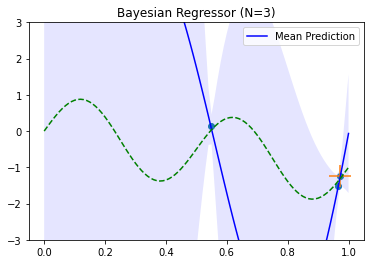

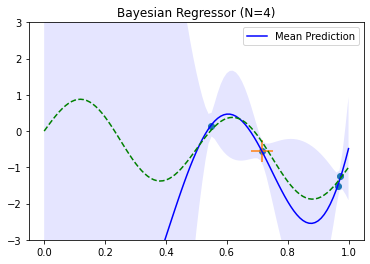

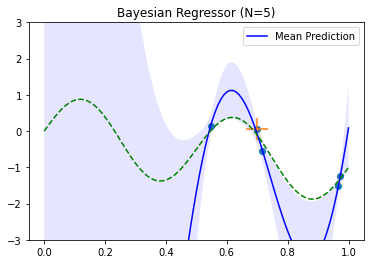

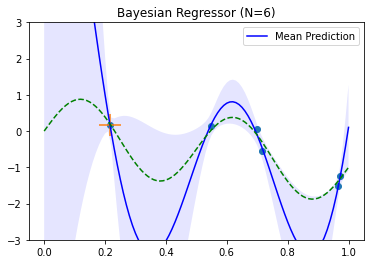

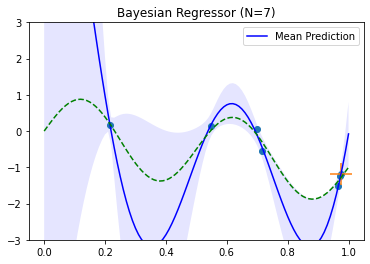

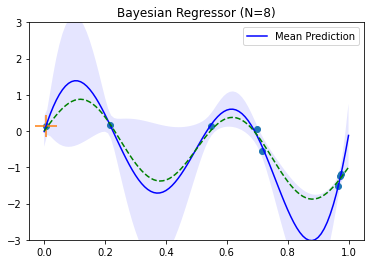

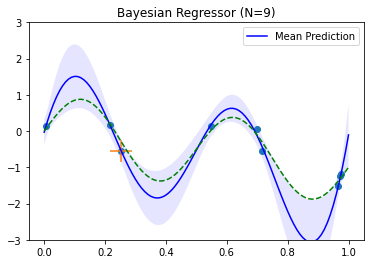

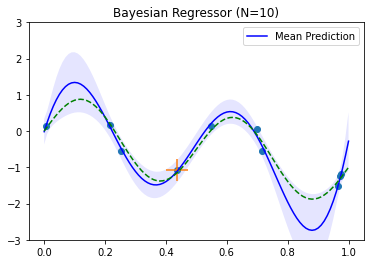

In [ ]:
# let's add the data one at a time
np.random.seed(seed)
N = 10
xs,ts = genData(N, beta)

for i in range(N+1):
  m_N, S_N = learnBayesianLR(xs[0:i], ts[0:i], locs=locs, shape=shape)

  # prediction 
  xp = np.array(np.arange(0.0, 1.01, 0.01)) #test points
  ys_mean_bayes, ys_std_bayes = predictBayesianLR(xp, m_N, S_N)

  # plotting 
  fig, ax = plotBayesianLR(xp, ys_mean_bayes, ys_std_bayes)
  ax.scatter(xs[0:i],ts[0:i])
  if i>0:
    ax.scatter(xs[i-1], ts[i-1], marker='+', s=500)
  ax.plot(xp, h(xp), 'g--', label="Actual")
  ax.set_title("Bayesian Regressor (N=%d)"%i)

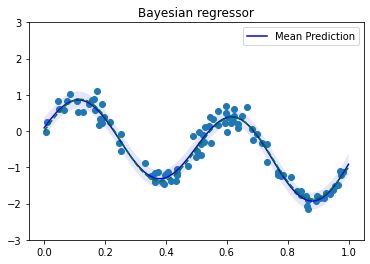

In [ ]:
np.random.seed(seed)

N = 100
xs,ts = genData(N, beta)

# learn
m_N, S_N = learnBayesianLR(xs, ts, locs=locs, shape=shape)

# prediction 
xp = np.array(np.arange(0.0, 1.01, 0.01)) #test points
ys_mean_bayes, ys_std_bayes = predictBayesianLR(xp, m_N, S_N)

# plotting 
fig, ax = plotBayesianLR(xp, ys_mean_bayes, ys_std_bayes)
ax.scatter(xs,ts)
ax.plot(xp, h(xp), 'g--', label="Actual")

## Recap
In this notebok, we have gotten a basic introduction to (i) averaging across datasets and (ii) then across weights using the Bayesian approach. Take some time to ensure you understand the key concepts during the lecture (especially about the bias-variance tradeoff) and feel free to play around with the models in this notebook. 